<a href="https://colab.research.google.com/github/DerekW00/afterimage-simulation/blob/main/afterimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Afterimage Modeling

 A reproduction of model in "A Computational Model of Afterimages"(2012) by Tobias Ritschel and Elmar Eisemann.
[Original Paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-8659.2012.03053.x)

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Data Preparation and Loading
Load an HDR or Tone-Mapped Image
* The “world radiance” $L_w(\vec{x}, \lambda)$ comes from an image.
* Use OpenCV (or PIL) to load your image, convert from BGR to RGB, and normalize pixel values to [0, 1].
* Convert the image to a PyTorch tensor and send it to the GPU.

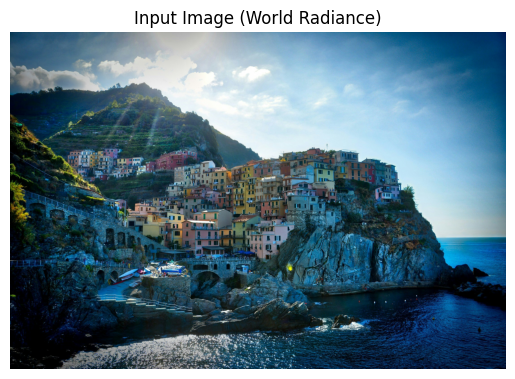

In [2]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Load image using OpenCV
img_bgr = cv2.imread('/content/drive/MyDrive/Colab Notebooks/afterimage/input_image/7.jpg')
if img_bgr is None:
    raise FileNotFoundError("Image not found. Check your file path.")
# Convert to RGB and normalize
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) / 255.0
# Convert to a PyTorch tensor and add batch and channel dimensions: [1, 3, H, W]
img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()

plt.imshow(img_rgb)
plt.title("Input Image (World Radiance)")
plt.axis('off')
plt.show()

## Simulate Eye Dynamic and Compute Effective Radiance

Eye Radiance:
- In the absence of eye tracking, assume fixation on the center and simulate micro-saccades by convolving with a small Gaussian Kernel

- This blurring represents the integration over time of small eye movements



In [3]:
import torch.nn.functional as F

def gaussian_kernel(kernel_size=5, sigma=1.5):
    """Create a 2D Gaussian kernel."""
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid(ax, ax)
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / torch.sum(kernel)
    return kernel

# Create a kernel and add dimensions for convolution: [out_channels, in_channels, H, W]
kernel_size = 5
sigma_blur = 1.5
gauss_kernel = gaussian_kernel(kernel_size, sigma_blur).unsqueeze(0).unsqueeze(0).cuda()

# Since our image has 3 channels, we can apply the same kernel to each channel using groups.
effective_radiance = F.conv2d(img_tensor, gauss_kernel.repeat(3, 1, 1, 1), padding=kernel_size//2, groups=3)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
effective_radiance

tensor([[[[0.0046, 0.0060, 0.0078,  ..., 0.0016, 0.0022, 0.0021],
          [0.0074, 0.0098, 0.0123,  ..., 0.0015, 0.0020, 0.0020],
          [0.0098, 0.0134, 0.0169,  ..., 0.0009, 0.0013, 0.0013],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0085, 0.0076, 0.0058],
          [0.0000, 0.0000, 0.0000,  ..., 0.0043, 0.0043, 0.0036],
          [0.0000, 0.0000, 0.0000,  ..., 0.0019, 0.0021, 0.0018]],

         [[0.0810, 0.1103, 0.1266,  ..., 0.0558, 0.0497, 0.0368],
          [0.1107, 0.1510, 0.1735,  ..., 0.0751, 0.0666, 0.0493],
          [0.1261, 0.1725, 0.1989,  ..., 0.0844, 0.0742, 0.0548],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0241, 0.0203, 0.0143],
          [0.0000, 0.0000, 0.0000,  ..., 0.0120, 0.0103, 0.0073],
          [0.0000, 0.0000, 0.0000,  ..., 0.0049, 0.0040, 0.0027]],

         [[0.1271, 0.1729, 0.1977,  ..., 0.2001, 0.1768, 0.1301],
          [0.1739, 0.2368, 0.2706,  ..., 0.2716, 0.2397, 0.1764],
          [0.1984, 0.2707, 0.3099,  ..., 0

## Convert from RGB to LMS Color Space

- The model uses conversion from RGB to LMS (and back) as part of the retinal processing.
- Approximate conversion matrices come from "Converting RGB Images to LMS Cone Activations" by Judah B. De Paula
[Original Paper](https://www.cs.utexas.edu/~ai-lab/pubs/tr06-49.pdf).
- Commonly used in projects. An example [here](https://github.com/esjastad/Color-Transfer/blob/d42931efa46ddcc739c2432126425a66869024a0/color_transfer.py#L23).

In [5]:
# Approximate conversion matrices (values taken from literature)
M_rgb_to_lms = torch.tensor([[0.3811, 0.5783, 0.0402],
                               [0.1967, 0.7244, 0.0782],
                               [0.0241, 0.1288, 0.8444]], dtype=torch.float32).cuda()

M_lms_to_rgb = torch.inverse(M_rgb_to_lms)

def convert_color_space(image, M):
    # image shape: [B, 3, H, W]. Reshape to [B, 3, N]
    B, C, H, W = image.shape
    flat = image.view(B, C, -1)
    converted = torch.matmul(M, flat)
    return converted.view(B, C, H, W)

# Convert effective radiance (RGB) to LMS
effective_radiance_lms = convert_color_space(effective_radiance, M_rgb_to_lms)

## Simulate Photoreceptor Adaptation (Retinal Kinetics)

### Step 1: Set Parameters and Initialize Opsin Concentration
- Use the Photoreceptor Adaptation Equation:
$$\dot{r}(x,t) = c_a\, L(x,t) \,(1 - r(x,t)) - c_d\, r(x,t)$$

- Choose $c_a, c_d$, and a time step $dt$

- Initialize $r$ (for each receptor in LMS space) to zero.

In [6]:
# Retinal kinetics parameters
c_a = 0.3   # activation rate (bleaching)
c_d = 1.0   # deactivation rate (recovery)
dt = 1.0 / 30.0  # time step (simulate 30 fps)
num_steps = 30   # simulate for 1 second

# Initialize opsin concentration in LMS space (same shape as effective radiance)
r_lms = torch.zeros_like(effective_radiance_lms).cuda()

### Step 2: Iterate using Euler Integration

- For eacth time step, update $r$ using differential equation
- After eaach update, apply a spatial Gaussian blur to simulate diffusion

#### **Recovery Process (Exponential Decay)**
$$
r(t) = R_{\infty} + (R_0 - R_{\infty}) e^{-t / \tau}
$$
where:
- $R_0$= **initial receptor state**.
- $R_{\infty}$ = **final adapted state**.
- $\tau$ = **time constant** (speed of adaptation).

#### **Diffusion**
- **Afterimages become progressively blurrier** over time.
- Modeled as a **Gaussian blur function**:
  $$
  \sigma = \frac{N_{\sigma}}{\sqrt{f}}
  $$
  - $N_{\sigma}$= scaling factor from experiments.
  - $f$ = frame rate.

In [7]:
# Prepare diffusion: Gaussian blur kernel for diffusion (diffusion sigma)
N_sigma = 10
sigma_diff = N_sigma / (30**0.5)  # using frame_rate=30
kernel_size_diff = 5  # can adjust based on desired diffusion amount
diff_kernel = gaussian_kernel(kernel_size_diff, sigma_diff).unsqueeze(0).unsqueeze(0).cuda()

# Iterate over time steps
for step in range(num_steps):
    # Compute differential change: r_dot = c_a * L * (1 - r) - c_d * r
    r_dot = c_a * effective_radiance_lms * (1 - r_lms) - c_d * r_lms
    # Euler integration update
    r_lms = r_lms + dt * r_dot
    # Clamp to [0, 1]
    r_lms = torch.clamp(r_lms, 0, 1)
    # Apply spatial diffusion (apply the blur to each channel separately)
    B, C, H, W = r_lms.shape
    r_lms = F.conv2d(r_lms, diff_kernel.repeat(C, 1, 1, 1), padding=kernel_size_diff//2, groups=C)

After these iterations, r_lms represents the adapted (bleached) opsin concentration in LMS space.

## Apply Chromatic Transformation

### Define the oRGB Transformation Matrices

- The model transforms LMS to an opponent space (oRGB) using a linear transformation.

- Define these matrices and use them to compute the complementary color (afterimage).

In [9]:
# Define transformation matrices (using common approximations)
M_lms_to_orgb = torch.tensor([[1/torch.sqrt(torch.tensor(3.0)),
                               1/torch.sqrt(torch.tensor(3.0)),
                               1/torch.sqrt(torch.tensor(3.0))],
                              [1/torch.sqrt(torch.tensor(6.0)),
                               1/torch.sqrt(torch.tensor(6.0)),
                               -2/torch.sqrt(torch.tensor(6.0))],
                              [1/torch.sqrt(torch.tensor(2.0)),
                               -1/torch.sqrt(torch.tensor(2.0)),
                               0]], dtype=torch.float32).cuda()
M_orgb_to_lms = torch.inverse(M_lms_to_orgb)

def convert_orgb(image_lms, to_orgb=True):
    # image_lms shape: [B, 3, H, W]
    if to_orgb:
        return convert_color_space(image_lms, M_lms_to_orgb)
    else:
        return convert_color_space(image_lms, M_orgb_to_lms)

# Convert bleaching result from LMS to opponent space (oRGB)
bleaching_orgb = convert_orgb(r_lms, to_orgb=True)

# Compute the complementary color (a simple inversion in opponent space)
afterimage_orgb = -bleaching_orgb

# Convert back from opponent space to LMS, then to RGB
afterimage_lms = convert_orgb(afterimage_orgb, to_orgb=False)
afterimage_rgb = convert_color_space(afterimage_lms, M_lms_to_rgb)
afterimage_rgb = torch.clamp(afterimage_rgb, 0, 1)

## Composite the Afterimage with the Original LDR Image

### Blend the afterimage and effective radiance

 Use a blending factor $\alpha$ (for example, 0.5) to composite the afterimage onto the original effective radiance.

In [10]:
alpha = 0.5
final_output = (1 - alpha) * effective_radiance + alpha * afterimage_rgb
final_output = torch.clamp(final_output, 0, 1)

## Display the Final Result

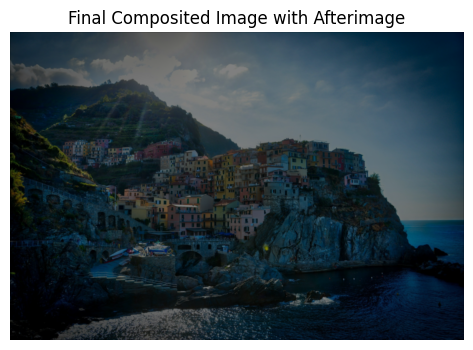

In [11]:
final_image = final_output.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(final_image)
plt.title("Final Composited Image with Afterimage")
plt.axis('off')
plt.show()